Harrison McGillen
Undergraduate Research Results Computation
Fall 2022
University of Montana, Geoscience

In [506]:
import pandas as pd
import numpy as np
import numpy.linalg as la
import scipy
import datetime as dt
import pdb
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
#!pip install tabulate
#from tabulate import tabulate

#function for determining a line of best fit
def bestfit(xx,yy,option):
    '''calculates best fit line and can output variables. for option: yhat = outputs
    best fit line, slope = outputs slope of the line, int = outputs y intercept'''
    xbar = xx.mean()
    ybar= yy.mean()
    sx = xx.std()
    sy = yy.std()
    r_xy = np.sum((xx-xbar)*(yy-ybar))/(np.sqrt(np.sum((xx-xbar)**2))*np.sqrt(np.sum((yy-ybar)**2)))
    me = r_xy * (sy / sx)
    be = ybar - me * xbar
    yhat = me*xx+be
    op = option
    if op == 'yhat':
        return yhat
    if op == 'slope':
        return me
    if op == 'int':
        return be

#Function for estalishing coverage percentage
def cov(foliage,total_d):
    coverage = foliage / total_d
    return coverage


In [507]:
#reading in some files

#this first one is for discharge data in West Glacier
disch_f = 'https://raw.githubusercontent.com/Harry1496/Capstone-Code/main/middlefork.txt'
disch_df =  pd.read_csv(disch_f,sep='\t',comment='#',
                       index_col='datetime',skiprows=[29],parse_dates=True)

rdict = {'82906_00060':'cfs'}
disch_df.rename(columns=rdict,inplace=True)
start = dt.datetime(2022,4,18)
end = dt.datetime(2022,9,30)

disch_df = disch_df.loc[(disch_df.index>=start) & (disch_df.index<=end)]


#This second one is for Meteorological data in Nyack

cfile = 'https://raw.githubusercontent.com/Harry1496/Capstone-Code/main/Met.dat'
clim_df = pd.read_csv(cfile,sep='\t',index_col='TIMESTAMP',skiprows=(0,2,3),parse_dates=True)
clim_df = clim_df.replace('\n','',regex=True)
clim_df = clim_df.loc[(clim_df.index>=start) & (clim_df.index<=end)]

clim_n = np.arange(0,len(clim_df.index),1)

avg_temp = bestfit(clim_n,clim_df['AirTC'],'yhat')

range1 = [i for i in range(0,365)]
clim_df['doy'] = clim_df.index.dayofyear

clim_df.head()



,RECORD,AirTC,RH,BP_mmHg,PAR_Den,SlrkW,Soil_T_C,VW,PA_uS,WindSpeed,WindDir,WindSpeed_S_WVT,WindDir_D1_WVT,WindDir_SD1_WVT,Rain_mm_Tot,AirTC_Max,AirTC_TMx,AirTC_Min,AirTC_TMn,doy
TIMESTAMP,,,,,,,,,,,,,,,,,,,,
2022-04-18 00:00:00,9882,-3.580,99.6,768.9,0.0,0.0,1.441,0.337,28.92,4.353,144.5,3.025,157.9,21.32,0.0,-2.966,4/17/2022 23:20,-3.580,4/18/2022 0:00,108
2022-04-18 01:00:00,9883,-4.491,99.2,768.1,0.0,0.0,1.427,0.337,28.92,4.171,109.8,2.909,128.9,21.69,0.0,-4.491,4/18/2022 1:00,-5.011,4/18/2022 0:30,108
2022-04-18 02:00:00,9884,-6.610,98.7,768.7,0.0,0.0,1.432,0.337,28.92,4.913,126.6,5.021,120.0,8.13,0.0,-4.491,4/18/2022 1:10,-6.610,4/18/2022 2:00,108
2022-04-18 03:00:00,9885,-8.180,96.5,767.9,0.0,0.0,1.436,0.337,28.92,0.921,286.8,4.227,136.9,53.02,0.0,-6.297,4/18/2022 2:20,-8.180,4/18/2022 3:00,108
2022-04-18 04:00:00,9886,-8.610,96.7,768.1,0.0,0.0,1.434,0.337,28.92,0.175,139.9,0.869,179.0,35.93,0.0,-7.424,4/18/2022 3:10,-8.920,4/18/2022 3:50,108


In [508]:
#Calculating Potential ET

#pulling mean air temp from climate data
means = clim_df.groupby(pd.Grouper(freq='1D')).mean()

#establishing given values
h = 964.1 #meters
T = means['AirTC'] #clim_n['AirTC']
A = 48.4950 #degrees
T_d = 3 #degrees c
T_m = T + 0.006*h

#calculations
E = ((700 * T_m /(100 - A)) + (15*(T-T_d)))/((80-T))
E = E.clip(lower=0)

#potential head gradient for August
ph_start = dt.datetime(2022,8,1)
ph_end = dt.datetime(2022,8,31)
ph_clim = E.loc[(E.index>=ph_start) & (E.index<=ph_end)]
#ph_clim = E

k = 400 #m/d
p_h = ph_clim/(k*1000) * 1000
#print(ph_clim, 'm/m')
#ph_clim.mean()
p_h.mean()

0.022057973714655198

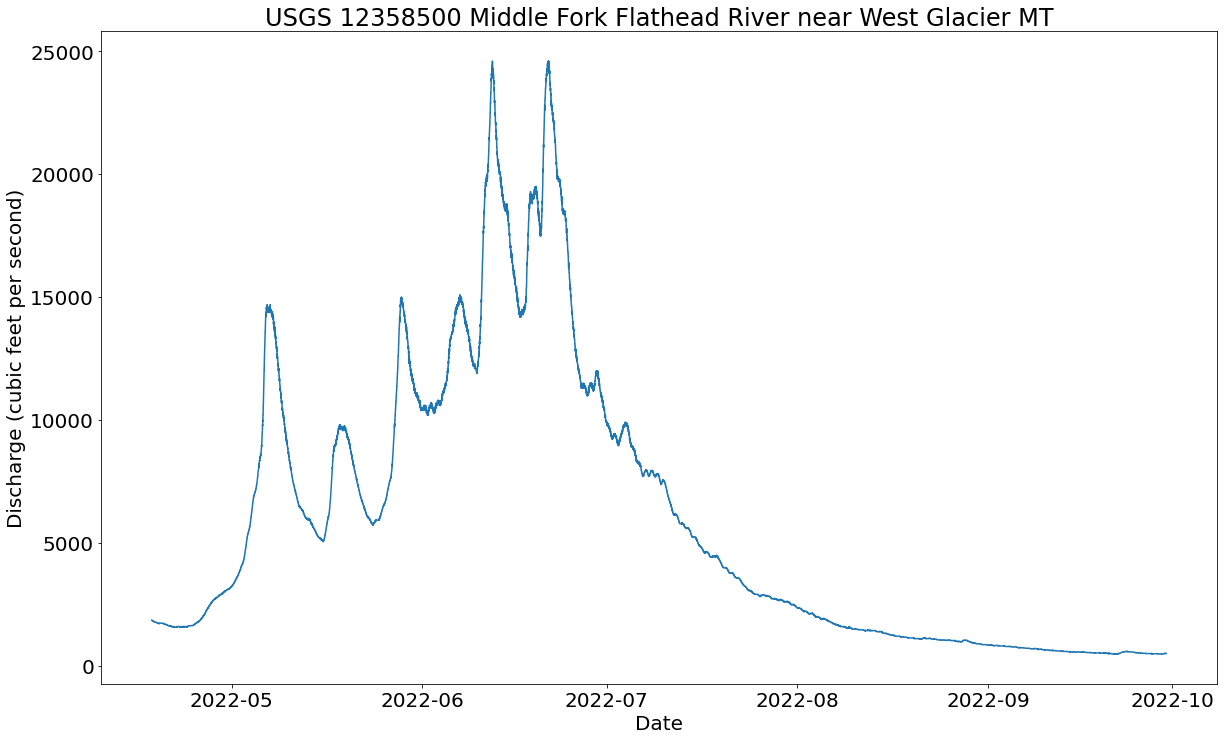

In [509]:
#Visualization of data sofar

fig,ax = plt.subplots(figsize=(20,12))
plt.rcParams['font.size'] = '20'
plt.plot(disch_df.index, disch_df['cfs'])
#plt.plot(clim_df.index,clim_df['AirTC']*100)
plt.xlabel('Date')
plt.ylabel('Discharge (cubic feet per second)')
plt.title('USGS 12358500 Middle Fork Flathead River near West Glacier MT')
plt.show()



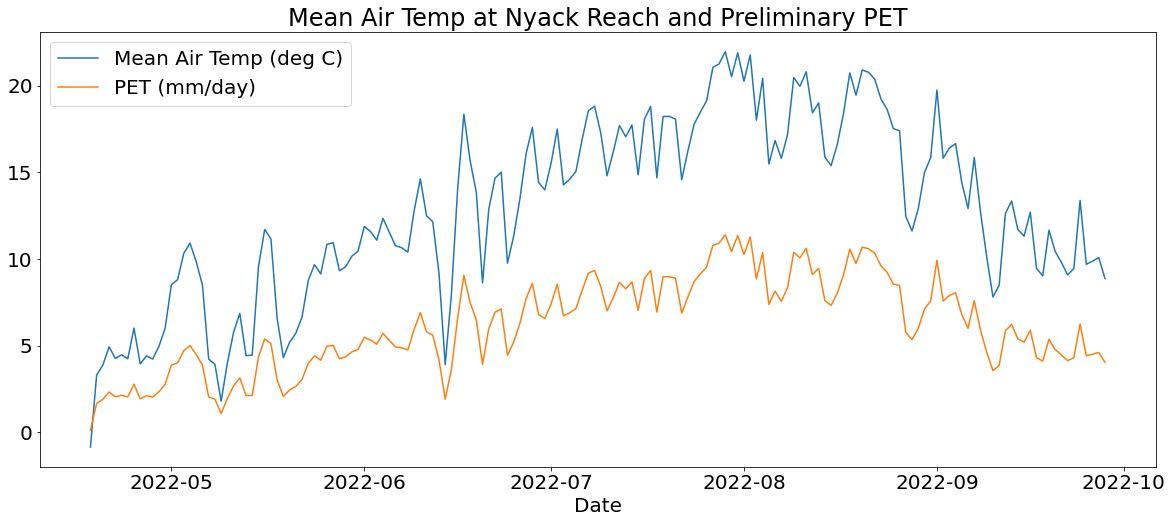

In [510]:
fig2,ax = plt.subplots(figsize=(20,8))
plt.rcParams['font.size'] = '20'
#plt.plot(clim_df.index,clim_df['AirTC'])
plt.plot(means.index,means['AirTC'],label="Mean Air Temp (deg C)")
plt.plot(means.index,E,label="PET (mm/day)")
plt.xlabel('Date')
#plt.ylabel('Mean Temperature (degrees C)')
ax.legend(loc="upper left")
plt.title("Mean Air Temp at Nyack Reach and Preliminary PET")
#plt.plot(clim_df.index,avg_temp,'b')
plt.show()

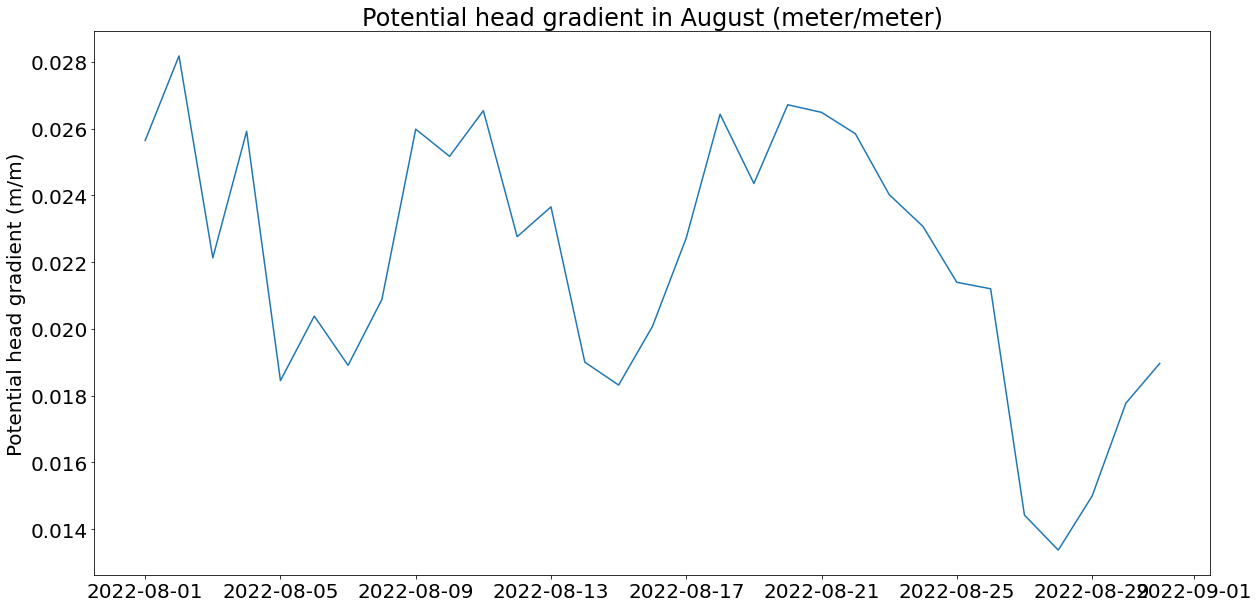

In [511]:
fig3,ax = plt.subplots(figsize=(20,10))
plt.plot(p_h.index,p_h)
plt.ylabel('Potential head gradient (m/m)')
plt.title('Potential head gradient in August (meter/meter)')
plt.show()

In [523]:
#Calculations for AET, a lot of these values will need revisited

lamb = 2.47e6 #j/kg^-1
delt = (4098*(0.6108**((17.27*clim_df['AirTC'])/(clim_df['AirTC']+237.3))))/((clim_df['AirTC']+237.3)**2)#slope of vapor pressure curve
delt = delt.groupby(pd.Grouper(freq='1D')).mean()
psyc = 0.665e-3       #psychometric constant

###calculations for net radiation###

#start with extraterrestrial radiation#
Gsc = 0.082 #(Mjm-2min-1) solar constant
dr1 = clim_df['doy'].groupby(pd.Grouper(freq='1D')).mean()
dr = 1 + (0.033*np.cos((((2*3.14)/365)*dr1))) #inverse relative distance Earth-Sun
temp = clim_df['AirTC'].groupby(pd.Grouper(freq='1D')).mean()
Rns = clim_df['SlrkW'] * 1000 # (J/s*m^2) net solar or net short wave radiation, direct measure 

Rn = clim_df['SlrkW'] * 3.6 # (MJ/s*m^2) #net radiation, assuming no longwave loss
Rn = Rn.groupby(pd.Grouper(freq='1D')).max()
k =  0.5         #light extinction coefficient
LAI = 4.0        #leaf area index
G = 0.1 * Rn  #soil heat flux
pa = 1.2      #air density (kgm^-2)
Cp = 1.01     #Specific heat of air (1.01 jkg^-1C^-1)
ea = (clim_df['RH']/100)
ea = ea.groupby(pd.Grouper(freq='1D')).mean()
#determining vapor pressure deficit, a bit more complicated
#need min and max daily temperatures
max1 = clim_df.groupby(pd.Grouper(freq='1D')).max()
max1 = max1['AirTC']
min1 = clim_df.groupby(pd.Grouper(freq='1D')).min()
min1 = min1['AirTC']

meanRH = clim_df.groupby(pd.Grouper(freq='1D')).mean()
meanRH = meanRH['RH']
eTmin = 0.6108**((17.27*min1)/(min1+237.3))
eTmax = 0.6108**((17.27*max1)/(max1+237.3))
esd = (eTmax+eTmin)/2 #mean saturation vp
ead = (meanRH/100)*esd #actual vp from relative humidity

D =  esd - ead     #vapor pressure deficit
#determining canopy resistance
hc = 2 #height of canopy(meters)
d = 0.67 * hc # zero plane displacement
z =  3  #where wind is measured, estimate and this should be checked#########
kv =  0.41     #von karman constant
z0 = 0.5    #roughness length, estimate and possible room for improvement
uh = clim_df['WindSpeed']
uh = uh.groupby(pd.Grouper(freq='1D')).mean()
ex = 0.4    #extinction coefficient
#step = (math.exp(-ex(1-(z/hc))))
uz = uh * (math.exp(-ex*(1-(z/hc))))    #wind velocity including extinction
ra =  (math.log((z-d)/(hc-d))*math.log((z-d)/z0))/((kv**2)*uz)              #aurodynamic resistance
W = 1         #soil water deficit
rs =  70        #surface resistance, s m-1
rc = 200        #canopy resistance, s m^-1

AET = ((delt*((Rn*math.exp(-k*LAI))-G)+(pa*Cp*(D/ra)))/((delt+psyc*(1+(rc/ra)))))

#AET_alt = ((0.408*delt*(Rn-G))+(psyc*(900/(temp+273))*(uh*D)))/(delt+(psyc*(1+0.34*uh)))

AETl = AET.loc[(AET.index>=ph_start) & (AET.index<=ph_end)]
AETl

TIMESTAMP
2022-08-01    2.025282
2022-08-02    2.422473
2022-08-03    2.022447
2022-08-04    2.512704
2022-08-05    2.128934
2022-08-06    2.150967
2022-08-07    1.447013
2022-08-08    1.421020
2022-08-09    1.727521
2022-08-10    0.897019
2022-08-11    1.116595
2022-08-12    0.928430
2022-08-13    1.173567
2022-08-14    1.462835
2022-08-15    1.360308
2022-08-16    1.325342
2022-08-17    1.358158
2022-08-18    1.605180
2022-08-19    1.263582
2022-08-20    1.610509
2022-08-21    1.012193
2022-08-22    1.204843
2022-08-23    1.608177
2022-08-24    1.576671
2022-08-25    0.870967
2022-08-26    1.119570
2022-08-27    0.832907
2022-08-28    0.905801
2022-08-29    0.962928
2022-08-30    0.925337
Freq: D, dtype: float64

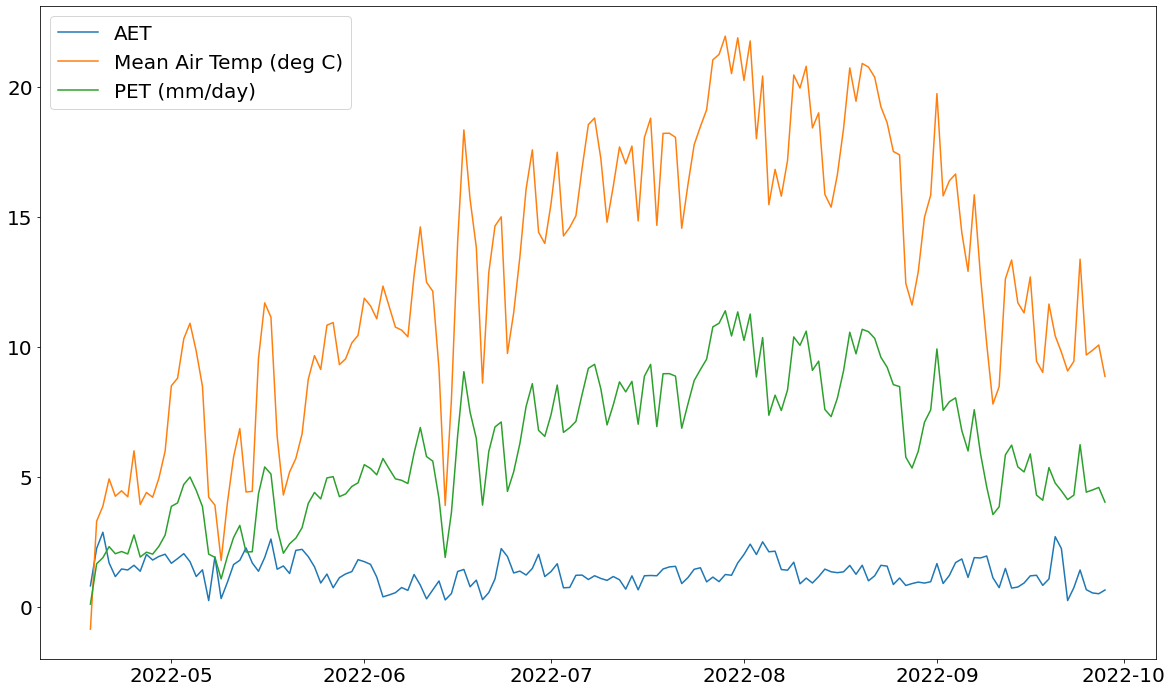

In [513]:
fig4,ax = plt.subplots(figsize=(20,12))
plt.plot(AET.index, AET,label="AET")
plt.plot(means.index,means['AirTC'],label="Mean Air Temp (deg C)")
plt.plot(means.index,E,label="PET (mm/day)")
ax.legend(loc="upper left")
plt.show()

In [514]:
#Read in Pizo data


hay_u = 'https://raw.githubusercontent.com/Harry1496/Capstone-Code/main/Hayfield_U.csv'
hay_udf =  pd.read_csv(hay_u,sep=',',comment='#',
                       index_col='Date and Time',skiprows=[i for i in range(0,70)],parse_dates=True)

hay_l = 'https://raw.githubusercontent.com/Harry1496/Capstone-Code/main/Hayfield_L.csv'
hay_ldf = pd.read_csv(hay_l,sep=',',comment='#',
                       index_col='Date and Time',skiprows=[i for i in range(0,70)],parse_dates=True)

rdict = {'Depth (cm)                              ':'depth','Pressure (kPa)                          ':'pressure',
        'Temperature (C)                         ':'temp'}
hay_udf.rename(columns=rdict,inplace=True)
hay_ldf.rename(columns=rdict,inplace=True)


p_h = p_h
p_h

TIMESTAMP
2022-08-01    0.025643
2022-08-02    0.028179
2022-08-03    0.022130
2022-08-04    0.025921
2022-08-05    0.018451
2022-08-06    0.020384
2022-08-07    0.018909
2022-08-08    0.020883
2022-08-09    0.025985
2022-08-10    0.025170
2022-08-11    0.026538
2022-08-12    0.022764
2022-08-13    0.023657
2022-08-14    0.019004
2022-08-15    0.018318
2022-08-16    0.020074
2022-08-17    0.022727
2022-08-18    0.026433
2022-08-19    0.024357
2022-08-20    0.026716
2022-08-21    0.026487
2022-08-22    0.025848
2022-08-23    0.024025
2022-08-24    0.023069
2022-08-25    0.021397
2022-08-26    0.021203
2022-08-27    0.014422
2022-08-28    0.013374
2022-08-29    0.014991
2022-08-30    0.017776
2022-08-31    0.018965
Freq: D, Name: AirTC, dtype: float64

In [515]:
dh = ((97-78)-(hay_udf['depth'] - (hay_ldf['depth'])))/100

print(dh.mean())
print(disch_df['cfs'].max())
print(disch_df['cfs'].min())

0.03530743729263436
24600
489


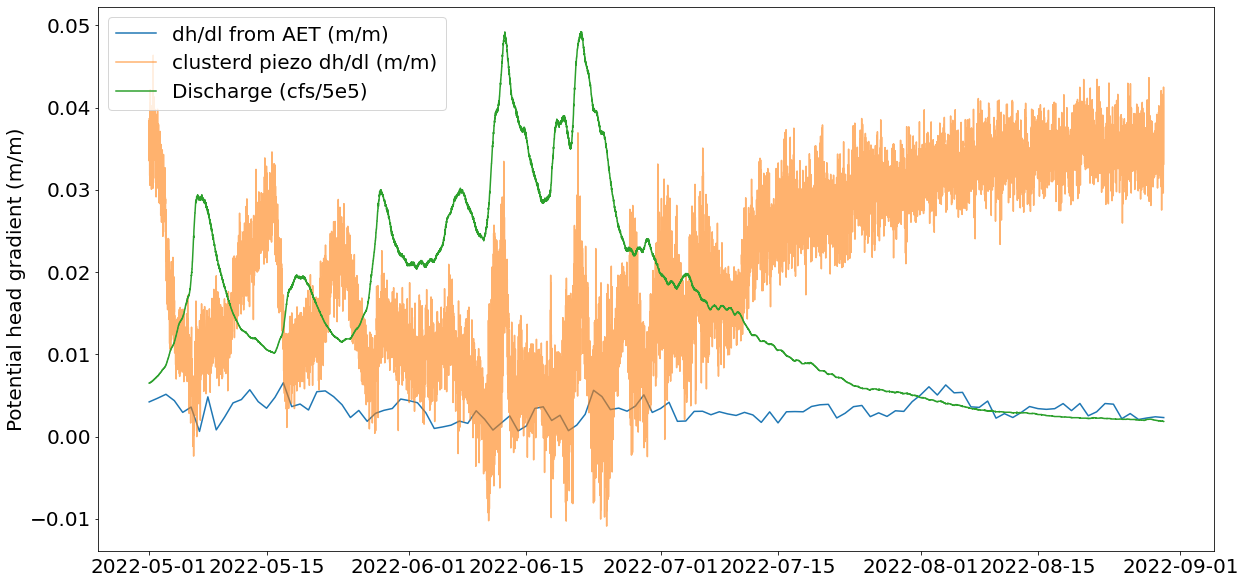

0.020752586726349397

In [525]:
#Calculating Potential dh/dl for AET

#potential head gradient for August
ph_start = dt.datetime(2022,5,1)
ph_end = dt.datetime(2022,8,30)
phA_clim = AET.loc[(AET.index>=ph_start) & (AET.index<=ph_end)]
p_h = p_h.loc[(p_h.index>=ph_start) & (p_h.index<=ph_end)]


dh_aug = dh.loc[(dh.index>=ph_start) & (dh.index<=ph_end)]

disch = disch_df['cfs']/500000
disch = disch.loc[(disch.index>=ph_start) & (disch.index<=ph_end)]

k = 400 #m/d
pA_h = phA_clim/(k*1000) * 1000
#print(p_h, 'm/m')
#print(pA_h, 'm/m')

fig3,ax = plt.subplots(figsize=(20,10))
#plt.plot(p_h.index,p_h)
plt.plot(pA_h.index,pA_h,label='dh/dl from AET (m/m)')
#plt.plot(p_h.index,p_h)
plt.plot(dh_aug.index,dh_aug,alpha=0.6,label='clusterd piezo dh/dl (m/m)')
plt.plot(disch.index,disch,label='Discharge (cfs/5e5) ')
#plt.plot(phA_clim.index, phA_clim)
plt.ylabel('Potential head gradient (m/m)')
plt.title('')
ax.legend(loc="upper left")

plt.show()


dh_aug.mean()


In [517]:
#fig = go.Figure()



#fig.add_trace(go.Scatter(dh,name=dh))

#fig.update_layout(autosize=False,width=700,height=500)

In [521]:
#Compilation of Results and Stat. significance
from scipy import stats

ph_start = dt.datetime(2022,8,1)
ph_end = dt.datetime(2022,8,30)
AET_aug = AET.loc[(AET.index>=ph_start) & (AET.index<=ph_end)] #AET for August
phA_aug =  AET_aug/(k*1000) * 1000 # Theoretical dh/dl from AET for August
ET_aug = E.loc[(E.index>=ph_start) & (E.index<=ph_end)] # PET for August
p_h_aug =  ET_aug/(k*1000) * 1000 #potential dh/dl from PET, for August
dh_aug = dh.loc[(dh.index>=ph_start) & (dh.index<=ph_end)] # observed dh/dl for August

print('PET',ET_aug.mean())
print('PET dh/dl',p_h_aug.mean())
print('AET',AET_aug.mean())
print('AET dh/dl',phA_aug.mean())
print('dh/dl obs',dh_aug.mean())


print(stats.ttest_ind(phA_aug,dh_aug))




PET 8.864432851693513
PET dh/dl 0.022161082129233792
AET 1.432642596671748
AET dh/dl 0.0035816064916793697
dh/dl obs 0.03419755475763016
Ttest_indResult(statistic=-58.65422286655795, pvalue=0.0)
